# PacBio vs Nanopore simulation

An analysis of whether different simulators, including a simulator of Nanopore data, affect ability to reconstruct SCRaMbLE sequences. What sequencing depth would one need to reconstruct a known SCRaMbLE solutions? Which strains can be solved?  

Here I compare reads simulated from [DAZZ_DB simulator](https://dazzlerblog.wordpress.com/command-guides/dazz_db-command-guide/) (PacBio read simulator) with [nanosim](https://github.com/bcgsc/NanoSim) (Nanopore read simualtor). I simulate reads from one the short-read SCRaMbLE solutions (by default, the first solution), assuming that this particular SCRaMbLE solutions is *correct*. I call this assumed solution the **true** solution. I then ask whether I can reconstruct this solution from the sequencing data alone.

Two important performance metrics:

**PER.COV** (percent coverage): fractional length of the longest overlapping and aligned contig to the true solution. Range 0.0-1.0. Higher values indicate more complete reconstructions

**MISASSEMBLY**: relative fractional length of aligned to the correct solution (PER.COV) relative to the fraction  length of the entire longest contig to the correct solution (CONTIG.TO.CORRECT). 1-(PER.COV/CONTIG.TO.CORRECT). Range 0.0-1.0. High-values indicate that the assembly is **misassembled**, i.e. has regions that do not align to the correct solution 

It's important to note that the reads simulated from the two methods are different. I report sequence recontructions at different *coverages*. While technically sound, this hides the fact that the underlying distribution of reads is different at the same coverage. On average, the Nanopore reads are nearly twice as long. Thus, at a particualar coverage, there are roughly half of the number of reads (Figure 1). These descrepencies are consistent with what we've seen from actual data produced by these technologies, so I kepy them. The PacBio simulation parameters are taken from results we generated. In addition, the error characteristics of Nanopore are different that PacBio. This in particular is what I was hoping to assess with this experiment. 

The whole pipeline from simulation to whole-genome alignment has been automated with Snakemake:
[Snakemake config file](Snakefile)

<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle code on/off."></form>

In [2]:
suppressMessages({
    .libPaths("~/R/x86_64-redhat-linux-gnu-library/3.2/")
    # config opts and libraries
    options(repr.plot.width = 6)
    options(repr.plot.height = 5)
    options(jupyter.plot_mimetypes = 'image/png')
    devtools::source_url("https://raw.githubusercontent.com/scalefreegan/R-tools/master/defaultRlibs.R")
    devtools::source_url("https://raw.githubusercontent.com/scalefreegan/steinmetz-lab/master/yeast2_0/scripts/seqtools.R")
})

In [10]:
baseDir = "/g/steinmetz/project/IESY/sequencing/Results/PacBio/Canu/AB/diff_simulators/"
# Find "true" sequence lengths from fasta
seqs = list.files("/g/steinmetz/brooks/git/steinmetz-lab/yeast2_0/scramble/seq/")
seqs = seqs[grepl("*_1.fasta$",seqs)]
PARENT_LENGTHS = lapply(seqs, function(i){
    f = file.path("/g/steinmetz/brooks/git/steinmetz-lab/yeast2_0/scramble/seq/",i)
    length(seqinr::read.fasta(f)[[1]])
})
names(PARENT_LENGTHS) = sapply(seqs,function(i){strsplit(i,split = "\\.")[[1]][1]})

rerun = F
if (!file.exists("results.rds") || rerun) {
    # read in aggregated results
    print("Loading aggStats.txt")
    results = data.frame(read_tsv(file.path(baseDir,"aggStats.txt"), col_names = T))
    saveRDS(results, "results.rds")
} else {
    results = readRDS("results.rds")
}

In [11]:
rerun = F
if (!file.exists("summary.rds")) {
    summary = results %>%
        separate(col = FNAME, into = c("tmp1","SIM"), sep = "(simulator|nanosim)/", extra="drop", fill="left") %>%
        separate(col = SIM, into = c("STRAIN","COVERAGE","REP"), sep = "_") %>%
        mutate(COVERAGE = as.numeric(gsub("c","",COVERAGE)),  
               REP = as.numeric(gsub(".originFix.txt","",REP)) )
    summary$tmp1 = NULL
    summary$PARENT.LENGTH = as.numeric(PARENT_LENGTHS[summary$REF])
    summary = summary %>% group_by(SAMPLE,STRAIN,COVERAGE,REP) %>% 
         summarise(PER.COV = max(LEN2)/max(PARENT.LENGTH), MAXCONTIGALIGN = max(LEN2))
    summary = summary %>% rowwise() %>% do({
        thisrow = .
        sample = paste(thisrow$STRAIN,paste("c",thisrow$COVERAGE,sep=""),thisrow$REP,sep="_")
        seqpath = paste("samples/",thisrow$SAMPLE,"/",sample,".fasta", sep="")
        assemblypath = paste("samples/assembly/",thisrow$SAMPLE,"/",sample,".contigs.fasta", sep="")
        # SEQS
        command_seq = paste("bioawk -c fastx '{ print $name, length($seq) }' <", seqpath, sep = "")
        bioawk_lens_seq = system(command_seq, intern=T)
        seqlens_seq = data.frame(bioawk_lens_seq, stringsAsFactors = F) %>% 
            separate(col = "bioawk_lens_seq", into = c("name","len"), sep = "\t")
        seqlens_seq$len = as.numeric(seqlens_seq$len)
        # ASSEMBLY
        command_assembly = paste("bioawk -c fastx '{ print $name, length($seq) }' <", assemblypath, sep = "")
        bioawk_lens_assembly = system(command_assembly, intern=T)
        seqlens_assembly = data.frame(bioawk_lens_assembly, stringsAsFactors = F) %>% 
            separate(col = "bioawk_lens_assembly", into = c("name","len"), sep = "\t")
        seqlens_assembly$len = as.numeric(seqlens_assembly$len)
        thisrow$NREADS = dim(seqlens_seq)[1]
        thisrow$MINREAD = as.numeric(min(seqlens_seq$len))
        thisrow$MEANREAD = as.numeric(mean(seqlens_seq$len))
        thisrow$MEDIANREAD = as.numeric(median(seqlens_seq$len))
        thisrow$MAXREAD = as.numeric(max(seqlens_seq$len))
        thisrow$MAXCONTIG = as.numeric(max(seqlens_assembly$len))
        thisrow$ACTUALCONTIG = unlist(PARENT_LENGTHS[paste(thisrow$STRAIN,"1",sep="_")])
        thisrow$MISASSEMBLY = 1 - (as.numeric(thisrow$PER.COV)/(as.numeric(thisrow$MAXCONTIG)/as.numeric(thisrow$ACTUALCONTIG)))
        o = data.frame(thisrow)
        return(o)
    })
} else {
    summary = readRDS("summary.rds")
}


In [12]:
pairwise = summary %>% group_by(STRAIN, COVERAGE, REP) %>% do({
    theserows = .
    #print(theserows)
    o = list()
    o$x = as.numeric(theserows[which(theserows$SAMPLE=="simulator"),"PER.COV"])
    o$y = as.numeric(theserows[which(theserows$SAMPLE=="nanosim"),"PER.COV"])
    return(data.frame(o))
})
pairwise2 = pairwise %>% group_by(STRAIN, COVERAGE) %>% summarise(x.m = mean(x), x.s = sd(x), y.m = mean(y), y.s = sd(y),
                                                             ymax = max(y), ymin = min(y),
                                                             xmax = max(x), xmin = min(x))

Warning message:
: Grouping rowwise data frame strips rowwise nature

## Figure 1:  Read number and read length are different between PacBio and Nanopore simulations

PacBio and Nanopore have different read characteristics inherently. This is also observed in simulation data. Both platforms have been normalized to a constant genome coverage that is calculated per sample. This leads to differences in the number of reads per simulation due to differences in read lengths. Nanopore reads are ~2X as long on average, so for a given coverage there are ~1/2 the number of reads. Unclear if this contributes to differences in assembly rates.


In [79]:
options(repr.plot.width = 10)
options(repr.plot.height = 3)
p1 <- ggplot(summary, aes(x=NREADS,y=MEANREAD, color=factor(SAMPLE))) +
    geom_point() + facet_wrap(~COVERAGE, ncol=4) + theme_bw() +
    xlab("Number of Reads") + ylab("Mean Read Length")

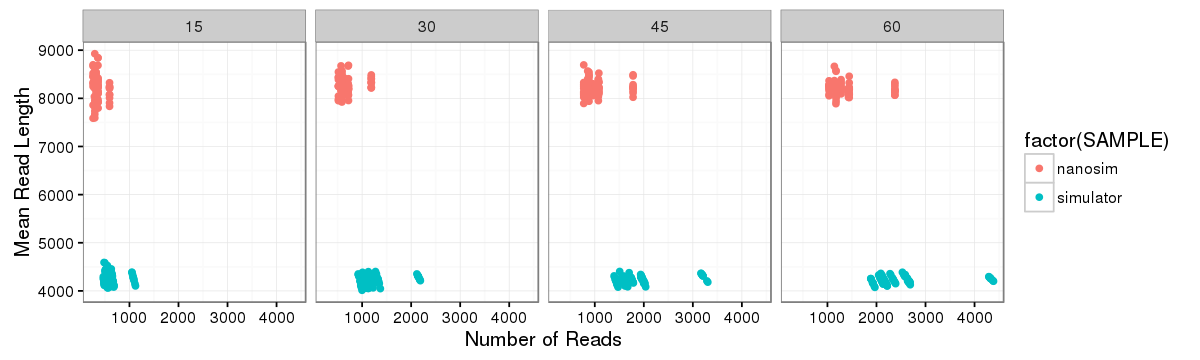

In [80]:
p1

## Figure 2:  PacBio based assemblies produce more complete reconstructions with lower misassembly rates

PacBio reads appear to produce more complete assemblies of some of the more difficult to assemble SynIXR SCRaMbLE strains. Each of 8 SCRaMbLE strains tested has more than one solution given short read sequencing data. These are among the harder SCRaMbLE to solve uniquely. PacBio based simulated reads are able to produce complete assemblies for 5 of these at some coverage (to 60X). At the same coverages, Nanopore simulations can only recover complete assemblies for 2. At the same time, the misassembly rate for Nanopore is much higher, suggesting that its reads (possibly due to some of the error characteristics) are more likely to produce incorrect assemblies, i.e. contain regions in assembled contig that do not match true solution. 


In [96]:
options(repr.plot.width = 8)
options(repr.plot.height = 12)
p2 <- ggplot(summary, aes(x=factor(COVERAGE),y=PER.COV)) + 
    geom_boxplot() + facet_grid(STRAIN~SAMPLE) + 
    geom_point(aes(fill=MISASSEMBLY),pch = 21, size = 2, position = position_jitterdodge(jitter.width=.5)) +
    scale_fill_gradient2(low="white",high="red",midpoint=0.25) + theme_bw() +
    xlab("COVERAGE")

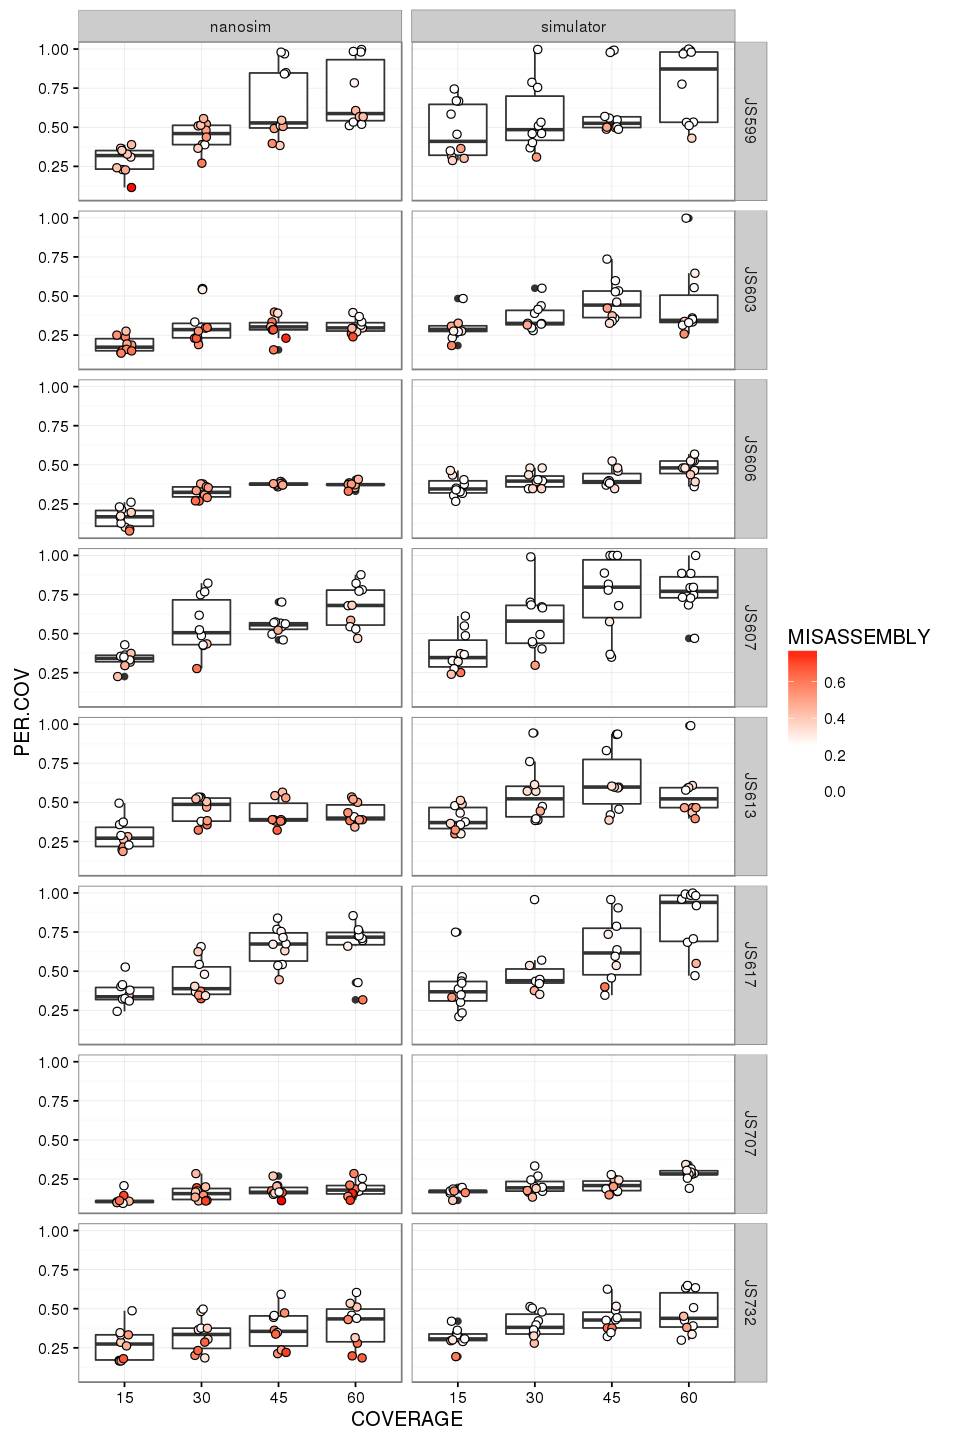

In [97]:
p2

## Figure 3:  Pairwise comparison of simulator (PacBio) and nanosim (Nanopore) based assemblies 

Similar to plot above, but showing pairwise performance across all strains. Clear skew to right (higher assembly rate in simulator-based assemblies) is clear. Lower panels show this more directly with the plot of density of of assembly rates for the two approaches

In [103]:
p3 <- ggplot(pairwise) 
p3.1 = p3 + geom_point(aes(x=x, y=y)) + xlim(c(0,1)) +
    ylim(c(0,1)) + ylab("PER.COV, nanopore") + xlab("PER.COV, pacbio") +
    facet_wrap(~COVERAGE, ncol = 5)
p3.2 = p3 + geom_density(aes(x)) + facet_wrap(~COVERAGE, ncol = 5) + xlab("PER.COV, pacbio (simulator)")
p3.3 = p3 + geom_density(aes(y)) + facet_wrap(~COVERAGE, ncol = 5) + xlab("PER.COV, nanopore (nanosim)")

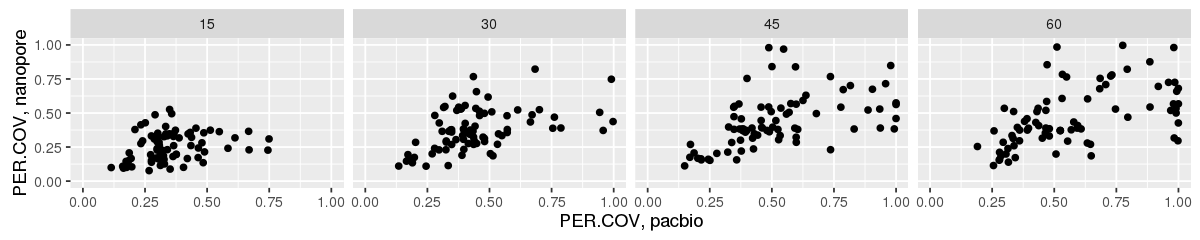

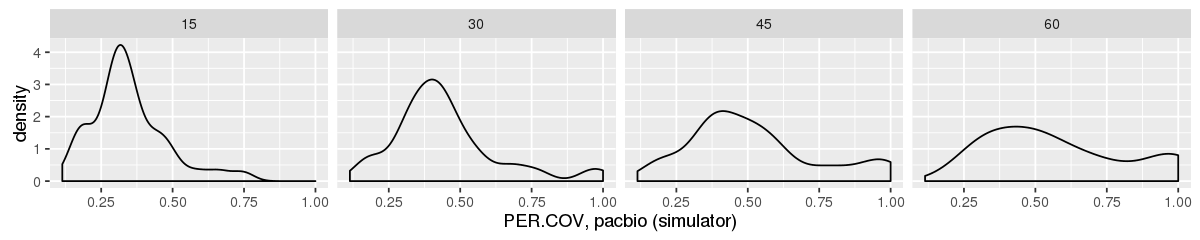

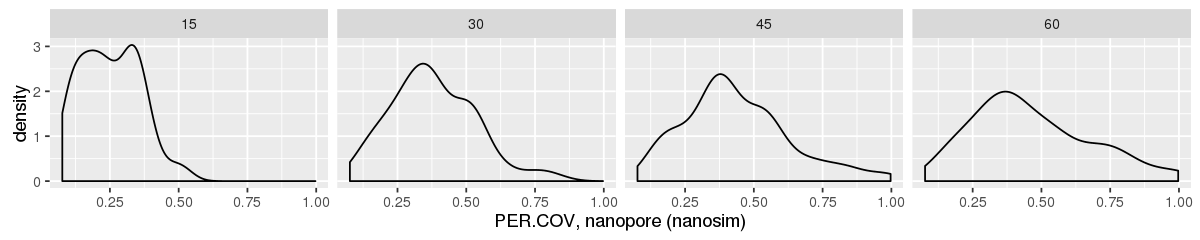

In [104]:
options(repr.plot.width = 10, repr.plot.height = 2)
p3.1
p3.2
p3.3